# MarathoNet

_MarathoNet_ es un sistema inteligente capaz de detectar el número de dorsal de corredores de maratón a partir del video extraído de una cámara que graba la carrera en un punto de control.

## Descripción del problema

Para poder identificar el dorsal de un corredor necesitamos detectar en tiempo real dónde se encuentra el cuerpo de éste en cada frame que extraemos de un vídeo que graba la carrera. 

En este notebook se plantea utilizar la librería _DLIB_ preentrenado con un modelo para la identificación de puntos clave de la cara. Los cuales podrán ser de utilidad para diseñar un subsistema de identificación y tracking de corredores de maratón.

## Pruebas iniciales con _DLIB_

Con el fin de familiarizarnos con la librería [_DLIB_](http://dlib.net/), disponemos de una serie de vídeos de personas moviéndose en una escena que utilizaremos como toma de contacto inicial con la librería y así observar todas la potencia y funcionalidades que esta ofrece.

### Carga de vídeos

Se procede con la carga de los diferentes archivos de vídeo que disponemos para realizar las pruebas con [_DLIB_](http://dlib.net/). Para ello, importaremos el módulo [_os_](https://docs.python.org/3/library/os.html) que permite el manejo de diferentes funcionalidades de sistema operativo, entre ellas, el manejo de ficheros y directorios.

In [1]:
import os

In [2]:
PATH = 'videos'
video_files = list()
for root, dirs, files in os.walk(os.path.relpath(PATH)):
    for file in files:
        video_files.append(os.path.join(root, file))

no_videos = len(video_files)
print(video_files)

['videos/01_03_03_27_08.mp4', 'videos/02_01_01_17_01.mp4', 'videos/03_02_02_30_04.mp4', 'videos/04_01_01_10_02.mp4', 'videos/05_01_02_08_01.mp4', 'videos/place3-3.mp4']


El manejo y procesado de videos será gestionado por la librería de visión por computador, [_OpenCV_](https://opencv.org/), que depende a su vez de la archiconocida librería de computación científica, [_Numpy_](https://www.numpy.org/). Mostraremos las imágenes que procesamos [_OpenCV_](https://opencv.org/) en el propio _Jupyter Notebook_, es por este motivo por el cuál también tendremos que importar la librería [Matplotlib](https://matplotlib.org/). A continuación, procederemos con la carga de sendos paquetes:

In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

El objeto _VideoCapture_ es el que recibe la entrada de vídeo. Este dispone de una serie de métodos que iremos utilizando a lo largo de las pruebas con [_MTCNN_](http://dlib.net/). Se crea un diccionario que contenga un objeto _VideoCapture_ para cada imagen que encontremos en el directorio donde almacenamos los archivos de vídeo.

In [4]:
keys = [ 'video_' + str(i+1) for i in range(len(video_files)) ]

videos = { k: cv.VideoCapture(cv.samples.findFileOrKeep(v)) for (k, v) in zip(keys, video_files) }

for k,v in videos.items():
    if not v.isOpened():
        print('Unable to open: \'' + k + '\'')
        exit(0)

print(videos)

{'video_1': <VideoCapture 0x7f4411ca16b0>, 'video_2': <VideoCapture 0x7f44102395b0>, 'video_3': <VideoCapture 0x7f4411ca1950>, 'video_4': <VideoCapture 0x7f4411ca16d0>, 'video_5': <VideoCapture 0x7f4411ca1730>, 'video_6': <VideoCapture 0x7f4411ca18b0>}


Seleccionaremos un frame arbitrario con el método _set()_ de cada objeto de la clase _VideoCapture_ generado en el paso anterior. El número máximo de frames de un video lo extraemos con el método _get()_ y el selector _cv.CAP_PROP_FRAME_COUNT_ de la clase _VideoCapture_. 

Tomamos un número entero aleatorio dentro del rango de frames que dispone cada vídeo para poder mostrar un frame aleatorio de la misma. Por este motivo tendremos que utilizar el método _randint()_ e importar la librería [random](https://docs.python.org/2/library/random.html).

Posteriormente, recuperamos el frame con el método _read()_ de la misma clase y lo mostraremos por pantalla utilizando el método _plt.imshow()_ de la librería [Matplotlib](https://matplotlib.org/).

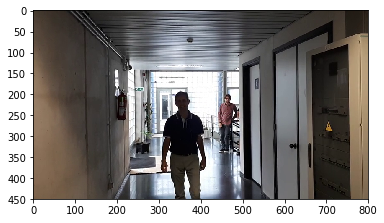

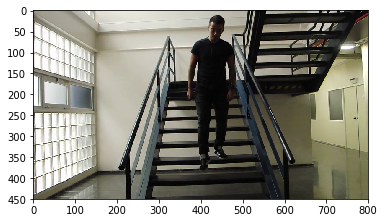

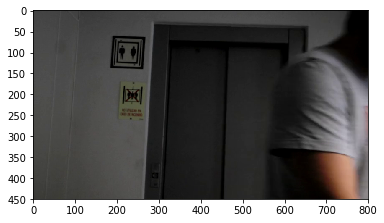

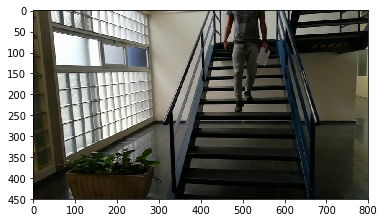

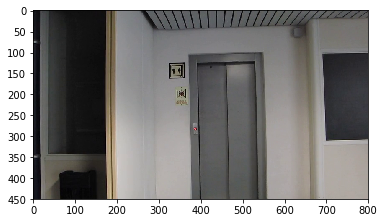

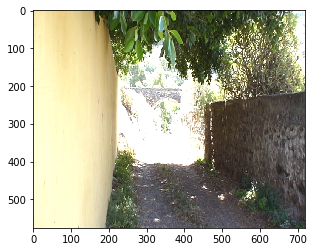

In [5]:
from random import randint

for i in range(no_videos):
    total_frames = videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_COUNT)
    actual_frame = randint(0, total_frames)
    
    videos['video_'+str(i+1)].set(cv.CAP_PROP_POS_FRAMES, actual_frame)
    
    ret, frame = videos['video_'+str(i+1)].read()
    img = cv.cvtColor(frame, cv.COLOR_BGR2RGBA)
    h,w = img.shape[:2]
    
    plt.imshow(img,cmap='gray')
    plt.show()

### Inferencia de puntos clave de la cara con _DLIB_

La librería [_DLIB_](http://dlib.net/) utiliza una red neuronal convolutiva que utiliza un método denominado [_Maximum-Margin Object Detection_](https://arxiv.org/pdf/1502.00046.pdf). Este modelo ha sido preentrenado con datasets como _ImageNet_, _PASCAL VOC_, _VGG_, _WIDER_, _Face Scrub_. El modelo preentrenado puede ser descargado del [repositorio oficial](https://github.com/davisking/dlib-models) de [_DLIB_](http://dlib.net/).

In [6]:
import dlib

Se procede a realizar la carga del modelo preentreando para la detección de regiones faciales y para la predicción de puntos clave de la cara.

In [7]:
FACE_DETECTOR_PATH = "models/mmod_human_face_detector/mmod_human_face_detector.dat"
FACE_PREDICTOR_PATH = "models/shape_predictor_68_face_landmarks/shape_predictor_68_face_landmarks.dat"

detector = dlib.cnn_face_detection_model_v1(FACE_DETECTOR_PATH)
predictor = dlib.shape_predictor(FACE_PREDICTOR_PATH)

#### Redimensión de frames de vídeo

Se procederá a implementar una pequeña función que que toma como entrada un frame de vídeo y lo redimensionará, conservando la proporción del mismo, a un tamaño máximo de 800x600 píxeles, siempre y cuando el frame de entrada supere dichas dimensiones. La redimensión de la imagen conlleva una interpolación de área de la imagen resultante (_cv.INTER_\__AREA_).

In [8]:
def define_size(inSize, outSize=(800,600)):
    w, h = inSize
    
    if w > outSize[0]:
        scaling = outSize[0] / w
        w = int(w * scaling)
        h = int(h * scaling)
        
    if h > outSize[1]:
        scaling = outSize[1] / h
        w = int(w * scaling)
        h = int(h * scaling)
        
    return (w, h)

In [9]:
def resize_frame(frame, inSize, outSize=(800,600)):
    dim = define_size(inSize, outSize)
    
    return cv.resize(frame, dim, interpolation=cv.INTER_AREA)

#### Detector de cara con _DLIB_

Se procede a implementar una pequeña función responsable de detectar regiones donde encontrar una cara de un sujeto dentro de cada fotograma de vídeo. Cada frame será reescalado antes de ser identificada la región en cuestión.

In [10]:
def infere_region(frame, detector, upsampling, inSize, outSize=(800,600)):
    return detector(resize_frame(frame, inSize, outSize), upsampling)

#### Infiriendo puntos clave de la cara con _DLIB_

A continuación se procede con la inferencia de puntos clave de la cara. Se devuelve un diccionario por fotograma procesado. Este diccionario tiene la estructura de salida del fichero _JSON_ sobre el cual se guardan los resultados de los puntos inferidos.

In [11]:
def infere_keypoints(frame, faces, predictor):
    data = { 'people': list() }
    
    for i, face in enumerate(faces):
        kp = predictor(frame, face.rect)
        data['people'].append( {'face_keypoints_2d': list()} )
        
        for j in range(kp.num_parts):
            data['people'][i]['face_keypoints_2d'].extend( [kp.part(j).x, kp.part(j).y] )
        
    return data        

#### Generando resultados

El objetivo de este apartado consiste en generar un un fichero _JSON_ por fotograma de vídeo con toda la información relativa a los puntos de interés de la cara detectada por [_DLIB_](http://dlib.net/). Deberemos importar además él módulo [_json_](https://docs.python.org/2/library/json.html) de Python.

In [12]:
import json
from datetime import date

today = date.today()
d1 = today.strftime("%d.%m.%Y")

OUT_PATH = "out/dlib_" + d1 + "/"

if not os.path.exists(OUT_PATH):
    os.mkdir(OUT_PATH)

for i, file_i in enumerate(video_files):
    file_i = os.path.splitext(os.path.split(file_i)[1])[0]
    
    if not os.path.exists(OUT_PATH + "video/"):
        os.mkdir(OUT_PATH + "video/")
        
    if not os.path.exists(OUT_PATH + "json/"):
        os.mkdir(OUT_PATH + "json/")
    
    if not os.path.exists(OUT_PATH + "video/" + file_i):
        os.mkdir(OUT_PATH + "video/" + file_i)
    
    if not os.path.exists(OUT_PATH +"json/" + file_i):
        os.mkdir(OUT_PATH + "json/" + file_i)
    
    total_frames = int(videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_COUNT))
    w = int(videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_WIDTH))
    h = int(videos['video_'+str(i+1)].get(cv.CAP_PROP_FRAME_HEIGHT))
    videos['video_'+str(i+1)].set(cv.CAP_PROP_POS_FRAMES, 0)
    
    print(file_i + ' :', total_frames)
    
    for j in range(total_frames):
        ret, frame = videos['video_'+str(i+1)].read()
        faces = infere_region(frame, detector, 1, (w,h))
        data = infere_keypoints(frame, faces, predictor)
        
        json_name = f'dlib_{file_i}_{j:09}.json'

        with open(OUT_PATH + "json/" + file_i + "/" + json_name, "w") as write_file:
            json.dump(data, write_file)

error: OpenCV(4.1.1-dev) /opt/opencv/modules/imgproc/src/resize.cpp:3720: error: (-215:Assertion failed) !ssize.empty() in function 'resize'
